# Всероссийский хакатон 2023  
https://hacks-ai.ru/hackathons.html?eventId=969091&caseEl=1001438&tab=1

#### Кейс от компании "Самолет"
Модель определения склонности клиента к приобретению машиноместа  

#### Постановка задачи:
 Ключевую роль в продажах играет эффективная целевая рассылка. Рассылки позволяют оперативно информировать клиентов об актуальных предложениях и сервисах компании. Однако каждая рассылка сопряжена с различными издержками, что может негативно сказаться на лояльности клиентов в долгосрочной перспективе. На основе больших данных о предыдущем опыте взаимодействия с клиентами участникам хакатона предстоит разработать модель, позволяющую прогнозировать вероятность покупки клиентами дополнительных услуг, в частности, приобретения машиномест в паркинге. Разработанное решение позволит компании снизить затраты и улучшить лояльность клиентов за счет более персонифицированного подхода.  

Презентация решения: https://docs.google.com/presentation/d/1H0JEf_7zsufTrdpKC1LM-ug1LwY3v_tE_tY6zLo2xgY/edit?usp=sharing  

In [630]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from scipy import stats

from tqdm import tqdm, trange

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [567]:
# Under/Over Sampling
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import RandomOverSampler, ADASYN, BorderlineSMOTE

In [568]:
# Подключаем дополнительные модели для формирования ансамбля
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from imblearn.ensemble import RUSBoostClassifier, BalancedRandomForestClassifier



from sklearn.metrics import roc_auc_score, roc_curve, f1_score, classification_report, precision_score, recall_score, f1_score

In [569]:
# Настройки
# Убираем ограничение отображемых колонок
pd.options.display.max_columns = None
pd.options.display.max_rows = 100
# Устанавливаем тему по умолчанию
sb_dark = sns.dark_palette('skyblue', 8, reverse=True) # teal
sns.set(palette=sb_dark)

### Загрузка данных

In [570]:
PATH = "../"
PATH_DATASETS = PATH + "datasets/"
train_filename = PATH_DATASETS + "train_dataset_Самолет.csv"
test_filename = PATH_DATASETS + "test.csv"
submission_filename = PATH_DATASETS + "submission.csv"

In [571]:
%%time
df_train = pd.read_csv(train_filename, parse_dates=["report_date"])
df_train.shape

D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\IPython\core\magics\execution.py:1335: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,821,822,825,826,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1

Wall time: 5.64 s


(14456, 2666)

<AxesSubplot:>

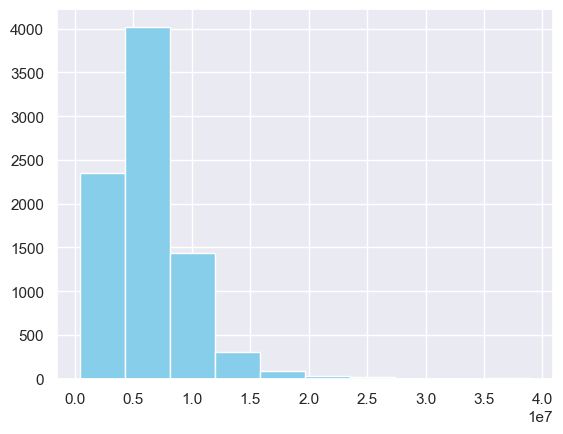

In [572]:
# Пример данных
df_train['col2565'].hist()

In [573]:
# Проверяем дисбаланс класса
df_train["target"].value_counts()

0    14020
1      436
Name: target, dtype: int64

### Исключаем признаки с большим кол-вом пропусков

In [574]:
# Смотрим сколько признаков имеют NaN для большинства объектов
# Отдельно по классам и если для обоих классов эти признаки не значимы, тогда удаляем признаки
threshold_drop = 0.7
nan_df_cls1 = df_train[df_train["target"] == 1].isna().sum()
nan_df_cls0 = df_train[df_train["target"] == 0].isna().sum()
count_cls1 = len(df_train[df_train["target"] == 1] )
count_cls0 = len(df_train[df_train["target"] == 0] )
drop_col_cls1 =  nan_df_cls1[nan_df_cls1 > count_cls1*threshold_drop]
drop_col_cls0 =  nan_df_cls0[nan_df_cls0 > count_cls0*threshold_drop]
drop_columns = set(drop_col_cls1.index)&set(drop_col_cls0.index)

# Исключаем признаки с большим кол-ом пропусков
df_train = df_train.drop(columns=drop_columns, errors='ignore')
df_train.shape

(14456, 543)

In [575]:
# df_train.reset_index()[["report_date", "client_id", "target"]].drop_duplicates(subset=["client_id", "target"])

In [576]:
# Анализ col1454 - признак схож с client_id
print(len(df_train), len(df_train['client_id'].unique()), df_train['col1454'].unique().shape)
df_train[df_train['col1454'] == '01febac0-b083-494e-8589-f98400074b94']

14456 4817 (4818,)


,report_date,client_id,target,col1453,col1454,col1455,col1456,col1457,col1458,col1459,col1460,col1461,col1462,col1463,col1464,col1465,col1466,col1467,col1468,col1469,col1470,col1471,col1472,col1473,col1474,col1475,col1476,col1477,col1478,col1479,col1480,col1481,col1482,col1483,col1484,col1485,col1486,col1487,col1488,col1489,col1490,col1491,col1492,col1493,col1494,col1495,col1496,col1497,col1498,col1499,col1500,col1501,col1502,col1503,col1504,col1505,col1506,col1507,col1508,col1509,col1510,col1511,col1512,col1513,col1514,col1515,col1516,col1517,col1518,col1519,col1520,col1521,col1522,col1523,col1524,col1525,col1526,col1527,col1528,col1529,col1530,col1531,col1532,col1533,col1534,col1535,col1536,col1537,col1538,col1539,col1540,col1541,col1542,col1543,col1544,col1545,col1546,col1547,col1548,col1549,col1550,col1551,col1552,col1553,col1554,col1555,col1556,col1557,col1558,col1559,col1560,col1561,col1562,col1563,col1564,col1565,col1566,col1567,col1568,col1569,col1570,col1571,col1572,col1573,col1574,col1575,col1576,col1577,col1578,col1579,col1580,col1581,col1582,col1583,col1584,col1585,col1586,col1587,col1588,col1589,col1590,col1591,col1592,col1593,col1594,col1595,col1596,col1597,col1598,col1599,col1600,col1601,col1602,col1603,col1604,col1605,col1606,col1607,col1608,col1609,col1610,col1611,col1612,col1613,col1614,col1615,col1616,col1617,col1618,col1619,col1620,col1621,col1622,col1623,col1624,col1625,col1626,col1627,col1628,col1629,col1630,col1631,col1632,col1633,col1634,col1635,col1636,col1637,col1638,col1639,col1640,col1641,col1642,col1643,col1644,col1645,col1646,col1823,col1824,col1825,col1826,col1827,col1828,col1829,col1830,col1831,col1832,col1833,col1834,col1835,col1836,col1837,col1838,col1839,col1840,col1841,col1842,col1843,col1844,col1845,col1846,col1847,col1848,col1849,col1850,col1851,col1852,col1853,col1854,col1855,col1856,col1857,col1858,col1859,col1860,col1861,col1862,col1863,col1864,col1865,col1866,col1867,col1868,col1869,col1870,col1871,col1872,col1873,col1874,col1875,col1876,col1877,col1878,col1879,col1880,col1881,col1882,col1883,col1884,col1885,col1886,col1887,col1888,col1889,col1890,col1891,col1892,col1893,col1894,col1895,col1896,col1897,col1898,col1899,col1900,col1901,col1902,col1903,col1904,col1905,col1906,col1907,col1908,col1909,col1910,col1911,col1912,col1913,col1914,col1915,col1916,col1917,col1918,col1919,col1920,col1921,col1922,col1923,col1924,col1925,col1926,col1927,col1928,col1929,col1930,col1931,col1932,col1933,col1934,col1935,col1936,col1937,col1938,col1939,col1940,col1941,col1942,col2167,col2168,col2169,col2170,col2171,col2172,col2173,col2174,col2175,col2176,col2177,col2178,col2179,col2180,col2181,col2182,col2183,col2184,col2185,col2186,col2187,col2188,col2189,col2190,col2208,col2209,col2210,col2211,col2212,col2213,col2214,col2215,col2216,col2220,col2221,col2222,col2232,col2233,col2234,col2235,col2236,col2237,col2238,col2239,col2240,col2244,col2245,col2246,col2280,col2281,col2282,col2283,col2284,col2285,col2286,col2287,col2288,col2292,col2293,col2294,col2304,col2305,col2306,col2307,col2308,col2309,col2310,col2311,col2312,col2316,col2317,col2318,col2328,col2329,col2330,col2331,col2332,col2333,col2334,col2335,col2336,col2340,col2341,col2342,col2352,col2353,col2354,col2355,col2356,col2357,col2358,col2359,col2360,col2364,col2365,col2366,col2376,col2377,col2378,col2379,col2380,col2381,col2382,col2383,col2384,col2388,col2389,col2390,col2403,col2404,col2405,col2406,col2407,col2408,col2412,col2413,col2414,col2427,col2428,col2429,col2430,col2431,col2432,col2436,col2437,col2438,col2448,col2449,col2450,col2451,col2452,col2453,col2454,col2455,col2456,col2460,col2461,col2462,col2466,col2467,col2468,col2470,col2479,col2480,col2481,col2482,col2483,col2484,col2485,col2486,col2487,col2488,col2489,col2490,col2491,col2492,col2493,col2494,col2495,col2496,col2497,col2498,col2499,col2500,col2501,col2502,col2503,col2504,col2505,col2506,col2507,col2508,col2509,col2510,col2511,col2512,col2513,col2514,col2515,col2516,col2517,col2518,co

In [577]:
# Итого принимаем, что col1454 это по сути и есть клиент, поэтому это притендент на удаление

### Обработка пропусков в данных 

In [578]:
target_column = 'target'
report_date_column = 'report_date'
id_client_columns = ["col1454", "client_id"]
feature_columns = list(set(df_train.columns) - set([report_date_column]) - set([target_column]) - set(id_client_columns))

In [579]:
# Поиск константных признаков
constant_features = []
# Если везде одно значение  - это константа
for column in feature_columns:
    if len(df_train[column].value_counts()) == 1:
        constant_features.append(column)
df_train = df_train.drop(columns=constant_features, errors='ignore')
feature_columns = list(set(feature_columns) - set(constant_features))
df_train.shape

(14456, 349)

In [580]:
# Не числовые признаки 
not_num_feature_columns = df_train.select_dtypes('object').columns
not_num_feature_columns = list(set(not_num_feature_columns)&set(feature_columns))
num_feature_columns = list(set(feature_columns) - set(not_num_feature_columns))

In [581]:
# При дальнейшем анализе выявлено, что выделенные категориальные признаки являются незначимыми, а также содержат много пропусков
# Поэтому зануляем категориальные признаки
feature_columns = list(set(feature_columns) - set(not_num_feature_columns))
not_num_feature_columns = []

In [582]:
# save_df_train = df_train.copy()
# df_train = save_df_train.copy()
df_train.shape

(14456, 349)

In [583]:
# Если параметр точно не категориальный, т.е. кардинальность высокая, то пропуски заполняем медианной
# Если параметр вероятнее всего категориальный, то заполняем пропуски как новая категория
# Все неопределенные заполняем самым частым значением
# Провереям кардинальность значений 
check_cardinality = df_train[num_feature_columns].apply(lambda x: x.nunique())
number_columns = list(check_cardinality[check_cardinality > 400].index)

# якобы категориальные признаки отрабатывают не очень хорошо
# cat_columns = list(check_cardinality[check_cardinality <= 2].index)
cat_columns = not_num_feature_columns

other_columns = list(set(num_feature_columns) - set(number_columns) - set(cat_columns))

# Заполняем пропуски частовстречающимися значениями
for cat_col in cat_columns:
    df_train[cat_col] = df_train[cat_col].fillna("unknown").astype(str)
    
# Заполняем медианными значениями
for num_col in number_columns:
    df_train[num_col] = df_train[num_col].fillna(df_train[num_col].median())

# Заполняем пропуски частовстречающимися значениями
for other_col in other_columns:
    df_train[other_col] = df_train[other_col].fillna(df_train[other_col].value_counts().index[0])

In [584]:
# # Проверяем уровень значимости p-value и уровень корреляции с целевой функцией
# # Если p-value высокое, а корреляция с таргетом низкая, тогда признак считается не значимым для предсказания
# high_p_value = []

# for column in num_feature_columns:
#     feat = df_train[column]
#     target = df_train[target_column]
#     res = stats.pearsonr(feat, target)
#     corr, p_value = res
#     if p_value > 0.05 and abs(corr) < 0.002:
#         high_p_value.append(column)         
# #         print(f"column: {column}, p_value ({p_value}) > 0.05, corr ({abs(corr)}) < 0.01")

# print(len(feature_columns))
# feature_columns = list(set(feature_columns) - set(high_p_value))
# num_feature_columns = list(set(num_feature_columns) - set(high_p_value))
# print(len(feature_columns))

# Дальнейший анализ показал, что исключение признков таким методом не дает существенного прироста скора

In [585]:
# Удаялем дубликаты строк когда все признаки повторяются и различна только дата репорта
df_train = df_train.drop_duplicates(subset=list(set(df_train.columns) - set(['report_date', 'target'])))
df_train.shape

(14309, 349)

In [586]:
# Проверяем что не осталось NaN
nan_df = df_train[feature_columns].isna().sum()
nan_df[nan_df > 0]

Series([], dtype: int64)

### Формируем обучающую и тестовые выборки

In [70]:
def split_by_client(df, test_size=0.5):
    """ Метод разделения трейн теста, таким образом чтобы одинаковые клиенты не попадали в разные наборы, 
    и при этом сохранилась стратификация по данным
    """
    clients_target_1 = df[df["target"] == 1]["client_id"].unique()
    clients_t1_train, clients_t1_test = train_test_split(clients_target_1, test_size=test_size, shuffle=True, random_state=53)
    
    clients_target_0 = df[df["target"] == 0]["client_id"].unique()
    clients_t0_train, clients_t0_test = train_test_split(clients_target_0, test_size=test_size, shuffle=True, random_state=53)
    
    clients_t0_train = list(set(clients_t0_train) - set(clients_t1_test))
    clients_t0_test = list(set(clients_t0_test) - set(clients_t1_train))
    
    train = pd.concat([df[(df['client_id'].isin(clients_t0_train))], df[(df['client_id'].isin(clients_t1_train))] ] )
    test = pd.concat([df[(df['client_id'].isin(clients_t0_test))], df[(df['client_id'].isin(clients_t1_test))]])
    
    train = train.drop_duplicates(subset=["report_date", "client_id"])
    test = test.drop_duplicates(subset=["report_date", "client_id"])
    
    return train, test

In [71]:
train_data, val_data = split_by_client(df_train, test_size=0.2)
val_data, test_data = split_by_client(val_data, test_size=0.5)

# Проверяем, что нет лика данных по клиентам между трайн/вал/тест
assert len(set(train_data["client_id"])&set(val_data["client_id"])) == 0, "Лик train val"
assert len(set(train_data["client_id"])&set(test_data["client_id"])) == 0, "Лик train test"
assert len(set(test_data["client_id"])&set(val_data["client_id"])) == 0, "Лик test val"

train_data.shape, test_data.shape, val_data.shape

((11397, 638), (1432, 638), (1480, 638))

In [72]:
# Проверяем дисбаланс разбиения train/val/test
train_data["target"].value_counts(), val_data["target"].value_counts(), test_data["target"].value_counts()

(0    11043
 1      354
 Name: target, dtype: int64,
 0    1439
 1      41
 Name: target, dtype: int64,
 0    1393
 1      39
 Name: target, dtype: int64)

In [73]:
X_train = train_data[feature_columns]
y_train = train_data[target_column]

X_val = val_data[feature_columns]
y_val = val_data[target_column]

X_test = test_data[feature_columns]
y_test = test_data[target_column]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

((11397, 615), (11397,), (1480, 615), (1480,), (1432,), (1432, 615))

### Применение сэмплеров для борьбы с дисбалансом
- OverSmaple: RandomOverSampler, ADASYN, BorderlineSMOTE
- UnderSmaple: TomekLinks

In [74]:
# Применяется как OverSampling так и UnderSampling
# k_over_sampler = 0.03
# prc_weight = min(y_train.value_counts())/max(y_train.value_counts())
# print(f"prc_weight: {prc_weight}")
# count_part_undering = prc_weight + (1 - prc_weight)*k_over_sampler
# print(f"count_part_undering: {count_part_undering}")
# X_train, y_train = RandomOverSampler(sampling_strategy=count_part_undering, random_state=53).fit_resample(X_train, y_train)
# X_train, y_train = BorderlineSMOTE(sampling_strategy=count_part_undering, random_state=53).fit_resample(X_train, y_train)
# X_train, y_train = TomekLinks().fit_resample(X_train, y_train)

# X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape

# По итогам анализа выявлено, что сэмплирование данных плохо работает для данного датасета

### Матрица корреляции

In [75]:
%%time
corr_matrix = df_train[feature_columns + [target_column]].corr()

Wall time: 14.9 s


Wall time: 965 ms


Text(0.5, 1.0, 'Матрица корреляции')

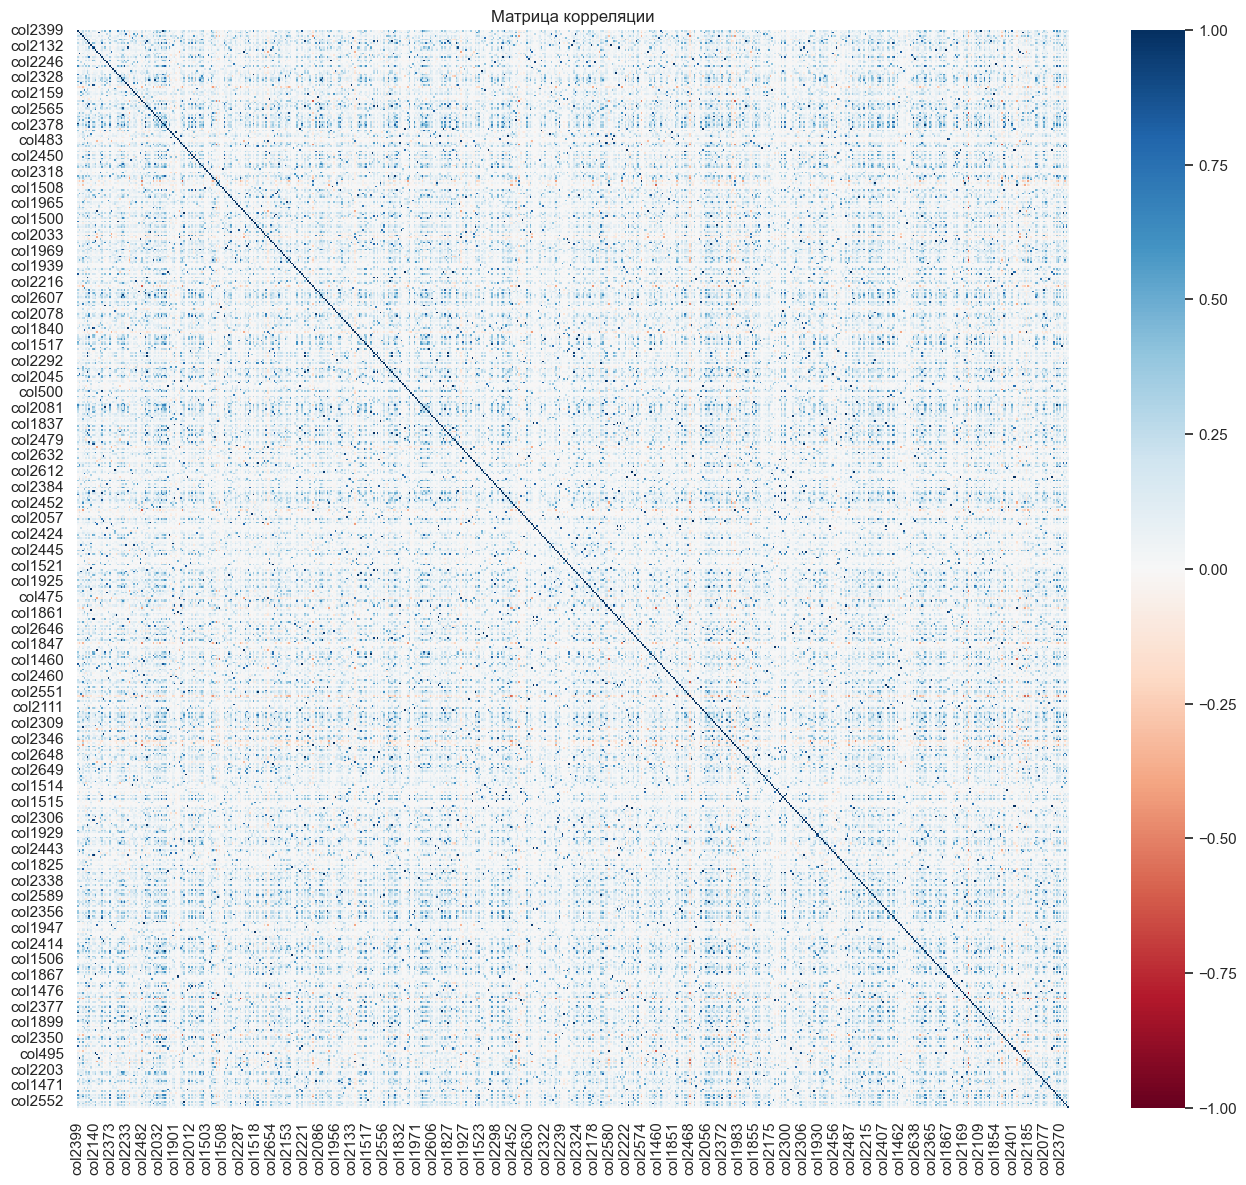

In [76]:
%%time
plt.figure(figsize=(16, 14))
heatmap = sns.heatmap(corr_matrix, vmin=-1, vmax=1, cmap='RdBu')
heatmap.set_title('Матрица корреляции');

### Построение модели

In [77]:
# Вывод графика ROC-AUC
def plot_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true=y_true, y_score=y_pred)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred)

    plt.figure(figsize=(10, 3))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.4f)' % roc_auc, alpha=0.5)

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.5)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver operating characteristic', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()
    return roc_auc

In [78]:
# Вывод графика feature importance
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать 
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

In [79]:
def metrics_classifie(y_test, y_pred,model, name='model'):
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f'{name} - Precision: {precision:.2f} | Recall: {recall:.2} | F1-score: {f1:.2} | ROCAUC: {roc_auc_score(y_true=y_test, y_score=model.predict_proba(X_test)[:,1])}')

In [80]:
# Расчет дисбалнса классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
class_weights

{0: 0.5160282531920674, 1: 16.097457627118644}

In [81]:
model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, class_weights=class_weights, cat_features=cat_columns, random_state=53)
model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

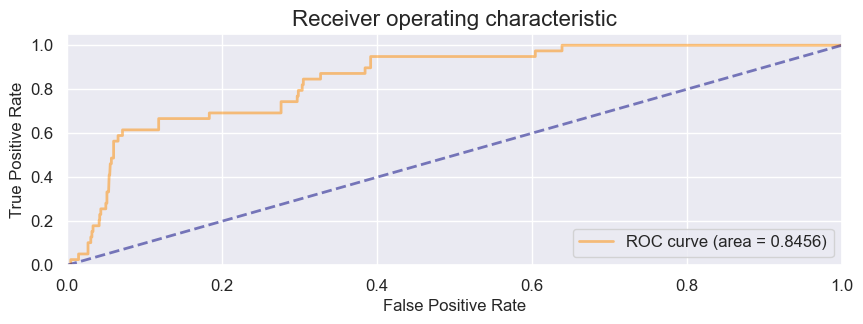

0.8456292451267325
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      1393
           1       0.13      0.62      0.22        39

    accuracy                           0.88      1432
   macro avg       0.56      0.75      0.58      1432
weighted avg       0.96      0.88      0.92      1432



In [82]:
# Для рассчета ROC-AUC на baseline моделе используем тестовые данные
y_pred_proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=y_pred_proba)
print(roc_auc)
print(classification_report(y_test, y_pred))

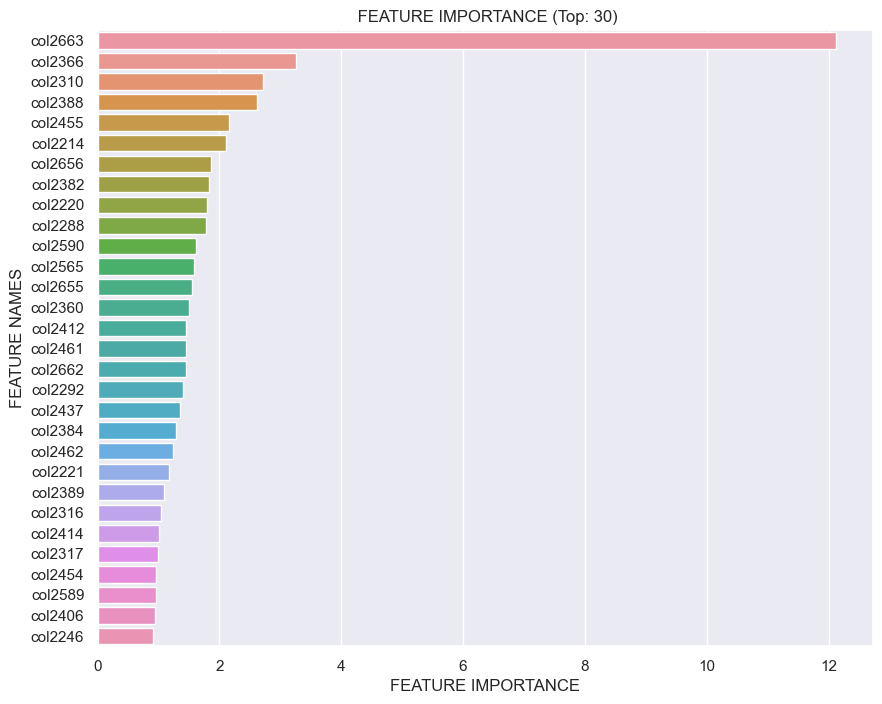

In [83]:
# Построение важности признаков
dfi = plot_feature_importance(model.get_feature_importance(), X_test.columns, top_n=30) 

In [84]:
dfi[:10]

,feature_names,feature_importance
127,col2663,12.115750
326,col2366,3.254719
75,col2310,2.714162
213,col2388,2.621955
466,col2455,2.166361
488,col2214,2.103789
533,col2656,1.870507
421,col2382,1.835318
44,col2220,1.805093
201,col2288,1.781447


<AxesSubplot:>

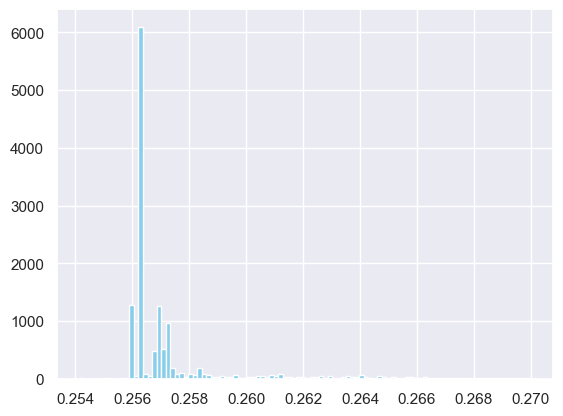

In [628]:
df_train[(df_train['col2663'] > 0.254)&(df_train['col2663'] < 0.27)]['col2663'].hist(bins=100)

### Кросс-валидация
Учитывая что разбиение на трейн/тест осуществляется особым методом, то стандартные методы кросс валидации CatBoost не подходят, необходимо производить собственное разбиение на фолды
- Разбиваем на фолды
- Обучаем k-1 модель
- Усредняем предсказания от разных моделей
- Проверяем на тесте

In [85]:
# Разбиваем на фолды
cv_count = 4
prc_size_fold = 100/(cv_count+1)

current_size = 100
folds_list = []
# Объединяем трайн и вал. Тест остается тестом
all_folds = pd.concat([train_data, val_data])
for i in range(cv_count-1):
    current_size -= prc_size_fold
    all_folds, current_fold = split_by_client(all_folds, test_size=prc_size_fold/current_size)
    folds_list.append(current_fold)
    # Проверяем, что нет лика данных по клиентам между трайн/вал/тест
    assert len(set(all_folds["client_id"])&set(current_fold["client_id"])) == 0, "Лик train val"
    assert len(set(all_folds["client_id"])&set(test_data["client_id"])) == 0, "Лик train test"
    assert len(set(test_data["client_id"])&set(current_fold["client_id"])) == 0, "Лик test val"
    
folds_list.append(all_folds)

In [86]:
%%time
# Обучаем k моделей
proba_predictions = []
for i in trange(cv_count):
    pool_train_data = folds_list.copy()
    
    val_data = pool_train_data.pop(i)
    train_data = pd.concat(pool_train_data)
    
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]

    X_val = val_data[feature_columns]
    y_val = val_data[target_column]

    # Проверяем, что нет лика данных по клиентам между трайн/вал/тест
    assert len(set(train_data["client_id"])&set(val_data["client_id"])) == 0, "Лик train val"
    assert len(set(train_data["client_id"])&set(test_data["client_id"])) == 0, "Лик train test"
    assert len(set(test_data["client_id"])&set(val_data["client_id"])) == 0, "Лик test val"        
    
    model = CatBoostClassifier(eval_metric = "AUC", early_stopping_rounds=200, class_weights=class_weights, cat_features=cat_columns, random_state=53)
    model.fit(X_train, y_train, eval_set=(X_val, y_val), plot=True, verbose=False)    
    
    y_pred = model.predict(X_test)
    metrics_classifie(y_test, y_pred, model)
    proba_predictions.append(model.predict_proba(X_test))


    
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape)

  0%|          | 0/4 [00:00<?, ?it/s]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 25%|██▌       | 1/4 [00:16<00:48, 16.21s/it]

model - Precision: 0.09 | Recall: 0.54 | F1-score: 0.16 | ROCAUC: 0.8256759990428332
(9723, 615) (9723,) (3154, 615) (3154,) (1432,) (1432, 615)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 50%|█████     | 2/4 [00:31<00:30, 15.44s/it]

model - Precision: 0.12 | Recall: 0.69 | F1-score: 0.21 | ROCAUC: 0.8765438916192685
(9670, 615) (9670,) (3207, 615) (3207,) (1432,) (1432, 615)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

 75%|███████▌  | 3/4 [00:45<00:14, 14.87s/it]

model - Precision: 0.09 | Recall: 0.51 | F1-score: 0.15 | ROCAUC: 0.8451598652603678
(9570, 615) (9570,) (3307, 615) (3307,) (1432,) (1432, 615)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

100%|██████████| 4/4 [00:59<00:00, 14.79s/it]

model - Precision: 0.10 | Recall: 0.62 | F1-score: 0.17 | ROCAUC: 0.838220406059602
(9668, 615) (9668,) (3209, 615) (3209,) (1432,) (1432, 615)
Wall time: 59.2 s


In [87]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

ROCAUC: 0.8726876138936441


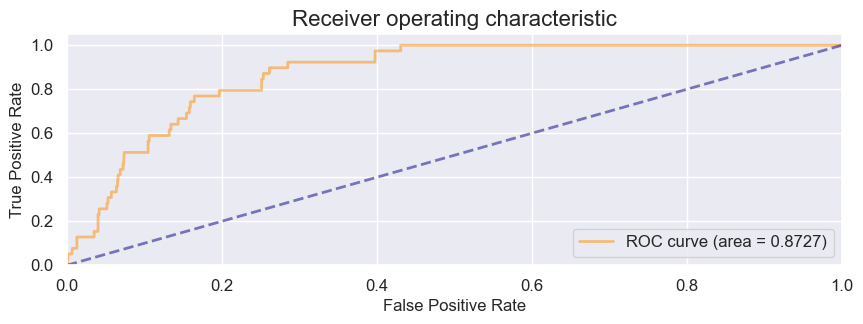

              precision    recall  f1-score   support

           0       0.99      0.87      0.92      1393
           1       0.11      0.62      0.19        39

    accuracy                           0.86      1432
   macro avg       0.55      0.74      0.56      1432
weighted avg       0.96      0.86      0.90      1432



0.8726876138936441

In [88]:
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=average_proba_predict[:,1])
print(classification_report(y_true=y_test, y_pred=[1 if pred >= 0.5 else 0 for pred in average_proba_predict[:,1]]))
roc_auc

### Feature engineering 

In [89]:
# Генерация фичей по принципу умножение самых важных фичей
# for col1 in list(dfi[:30]['feature_names'])[:10]:
#     for col2 in list(dfi[:30]['feature_names'])[:10]:
#         if col1 in num_feature_columns and col2 in num_feature_columns:
#             print(new_column)
#             new_column = f"{col1}_{col2}"
#             df_train[new_column] = df_train[col1] * df_train[col2]
#             feature_columns.append(new_column)


# Данный подход не добавил значимого скора

### Ансамбль моделей классификации

In [188]:
scale_pos_weight = len(df_train[df_train['target']==0])/len(df_train[df_train['target']==1])
prc_weight = min(y_train.value_counts())/max(y_train.value_counts())
classifiers = [
               ['BalancedBaggingClassifier :', BalancedBaggingClassifier(n_estimators=200, max_samples=prc_weight, random_state=53)],
               ['EasyEnsembleClassifier :', EasyEnsembleClassifier(random_state=53)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier(class_weight=class_weights, random_state=53)],
               ['RandomForest :', RandomForestClassifier(n_estimators=200, class_weight=class_weights, random_state=53)],
               ['AdaBoostClassifier :', AdaBoostClassifier(random_state=53)],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier(random_state=53)],
               # ['XGB :', XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=53)],
               ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=53)],
               ['CatBoost :', CatBoostClassifier(class_weights=class_weights, cat_features=cat_columns, verbose=False, random_state=53)]]
        

In [189]:
%%time
# Обучаем k моделей
proba_predictions = []
for i in trange(cv_count):
    pool_train_data = folds_list.copy()
    
    val_data = pool_train_data.pop(i)
    train_data = pd.concat(pool_train_data)
    
    X_train = train_data[feature_columns]
    y_train = train_data[target_column]

    X_val = val_data[feature_columns]
    y_val = val_data[target_column]

    # Проверяем, что нет лика данных по клиентам между трайн/вал/тест
    assert len(set(train_data["client_id"])&set(val_data["client_id"])) == 0, "Лик train val"
    assert len(set(train_data["client_id"])&set(test_data["client_id"])) == 0, "Лик train test"
    assert len(set(test_data["client_id"])&set(val_data["client_id"])) == 0, "Лик test val"        
    
    for name, model in tqdm(classifiers):
        print(name)
        model.fit(X_train, y_train)  # Предполагается, что X_train и y_train подготовлены
        y_pred = model.predict(X_test)
        metrics_classifie(y_test, y_pred, model, name)
        proba_predictions.append(model.predict_proba(X_test))
    
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, y_test.shape, X_test.shape)

  0%|          | 0/8 [00:00<?, ?it/s]

BalancedBaggingClassifier :
BalancedBaggingClassifier : - Precision: 0.08 | Recall: 0.79 | F1-score: 0.15 | ROCAUC: 0.8033022254127782



 12%|█▎        | 1/8 [00:05<00:35,  5.06s/it]

EasyEnsembleClassifier :
EasyEnsembleClassifier : - Precision: 0.10 | Recall: 0.74 | F1-score: 0.17 | ROCAUC: 0.8525595008007069



 25%|██▌       | 2/8 [00:18<00:59,  9.86s/it]

ExtraTreesClassifier :



 38%|███▊      | 3/8 [00:21<00:35,  7.02s/it]

ExtraTreesClassifier : - Precision: 0.50 | Recall: 0.026 | F1-score: 0.049 | ROCAUC: 0.771375190973181
RandomForest :


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 4/8 [00:27<00:26,  6.61s/it]

RandomForest : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.7521950411397648
AdaBoostClassifier :



 62%|██████▎   | 5/8 [00:34<00:19,  6.47s/it]

AdaBoostClassifier : - Precision: 0.14 | Recall: 0.026 | F1-score: 0.043 | ROCAUC: 0.7682828059712482
GradientBoostingClassifier: 



 75%|███████▌  | 6/8 [00:56<00:23, 11.71s/it]

GradientBoostingClassifier:  - Precision: 0.50 | Recall: 0.026 | F1-score: 0.049 | ROCAUC: 0.7883004767426878
LGBM :



 88%|████████▊ | 7/8 [00:58<00:08,  8.59s/it]

LGBM : - Precision: 0.09 | Recall: 0.026 | F1-score: 0.04 | ROCAUC: 0.757643529000313
CatBoost :



 25%|██▌       | 1/4 [01:56<05:48, 116.00s/it]

CatBoost : - Precision: 0.31 | Recall: 0.13 | F1-score: 0.18 | ROCAUC: 0.820347157030574
(9723, 615) (9723,) (3154, 615) (3154,) (1432,) (1432, 615)



  0%|          | 0/8 [00:00<?, ?it/s]

BalancedBaggingClassifier :
BalancedBaggingClassifier : - Precision: 0.08 | Recall: 0.69 | F1-score: 0.14 | ROCAUC: 0.8262098035967382



 12%|█▎        | 1/8 [00:06<00:44,  6.38s/it]

EasyEnsembleClassifier :
EasyEnsembleClassifier : - Precision: 0.09 | Recall: 0.72 | F1-score: 0.16 | ROCAUC: 0.8549708248200711



 25%|██▌       | 2/8 [00:17<00:55,  9.24s/it]

ExtraTreesClassifier :



 38%|███▊      | 3/8 [00:21<00:32,  6.58s/it]

ExtraTreesClassifier : - Precision: 1.00 | Recall: 0.026 | F1-score: 0.05 | ROCAUC: 0.8314097962339169
RandomForest :


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 4/8 [00:26<00:24,  6.20s/it]

RandomForest : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.8325510335560586
AdaBoostClassifier :



 62%|██████▎   | 5/8 [00:32<00:18,  6.19s/it]

AdaBoostClassifier : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.8569311760266534
GradientBoostingClassifier: 



 75%|███████▌  | 6/8 [00:56<00:24, 12.21s/it]

GradientBoostingClassifier:  - Precision: 0.29 | Recall: 0.051 | F1-score: 0.087 | ROCAUC: 0.8488412759769545
LGBM :



 88%|████████▊ | 7/8 [00:59<00:09,  9.12s/it]

LGBM : - Precision: 0.19 | Recall: 0.077 | F1-score: 0.11 | ROCAUC: 0.8502033979420914
CatBoost :



 50%|█████     | 2/4 [03:59<04:01, 120.62s/it]

CatBoost : - Precision: 0.10 | Recall: 0.026 | F1-score: 0.041 | ROCAUC: 0.8336922708782005
(9670, 615) (9670,) (3207, 615) (3207,) (1432,) (1432, 615)



  0%|          | 0/8 [00:00<?, ?it/s]

BalancedBaggingClassifier :
BalancedBaggingClassifier : - Precision: 0.06 | Recall: 0.56 | F1-score: 0.11 | ROCAUC: 0.8047563826458299



 12%|█▎        | 1/8 [00:05<00:37,  5.31s/it]

EasyEnsembleClassifier :
EasyEnsembleClassifier : - Precision: 0.07 | Recall: 0.64 | F1-score: 0.12 | ROCAUC: 0.806376203361128



 25%|██▌       | 2/8 [00:16<00:54,  9.01s/it]

ExtraTreesClassifier :



 38%|███▊      | 3/8 [00:20<00:32,  6.55s/it]

ExtraTreesClassifier : - Precision: 1.00 | Recall: 0.026 | F1-score: 0.05 | ROCAUC: 0.7759309367349569
RandomForest :


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 4/8 [00:26<00:25,  6.36s/it]

RandomForest : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.8455556169124009
AdaBoostClassifier :



 62%|██████▎   | 5/8 [00:33<00:19,  6.40s/it]

AdaBoostClassifier : - Precision: 0.20 | Recall: 0.026 | F1-score: 0.045 | ROCAUC: 0.7842233143740682
GradientBoostingClassifier: 



 75%|███████▌  | 6/8 [00:56<00:24, 12.10s/it]

GradientBoostingClassifier:  - Precision: 0.29 | Recall: 0.051 | F1-score: 0.087 | ROCAUC: 0.7918622416109854
LGBM :



 88%|████████▊ | 7/8 [00:58<00:08,  8.97s/it]

LGBM : - Precision: 0.14 | Recall: 0.051 | F1-score: 0.075 | ROCAUC: 0.8150919432326468
CatBoost :



 75%|███████▌  | 3/4 [06:01<02:00, 120.87s/it]

CatBoost : - Precision: 0.27 | Recall: 0.077 | F1-score: 0.12 | ROCAUC: 0.851418263478565
(9570, 615) (9570,) (3307, 615) (3307,) (1432,) (1432, 615)



  0%|          | 0/8 [00:00<?, ?it/s]

BalancedBaggingClassifier :
BalancedBaggingClassifier : - Precision: 0.08 | Recall: 0.72 | F1-score: 0.15 | ROCAUC: 0.8302869659653579



 12%|█▎        | 1/8 [00:05<00:40,  5.78s/it]

EasyEnsembleClassifier :
EasyEnsembleClassifier : - Precision: 0.08 | Recall: 0.62 | F1-score: 0.14 | ROCAUC: 0.7785631453973162



 25%|██▌       | 2/8 [00:17<00:55,  9.24s/it]

ExtraTreesClassifier :


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 38%|███▊      | 3/8 [00:21<00:33,  6.69s/it]

ExtraTreesClassifier : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.819712113681963
RandomForest :


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))

 50%|█████     | 4/8 [00:27<00:25,  6.38s/it]

RandomForest : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.7917978169234451
AdaBoostClassifier :



 62%|██████▎   | 5/8 [00:33<00:18,  6.31s/it]

AdaBoostClassifier : - Precision: 0.00 | Recall: 0.0 | F1-score: 0.0 | ROCAUC: 0.6925930016382278
GradientBoostingClassifier: 



 75%|███████▌  | 6/8 [00:56<00:24, 12.09s/it]

GradientBoostingClassifier:  - Precision: 0.20 | Recall: 0.026 | F1-score: 0.045 | ROCAUC: 0.8414232333830324
LGBM :



 88%|████████▊ | 7/8 [00:59<00:09,  9.27s/it]

LGBM : - Precision: 0.20 | Recall: 0.026 | F1-score: 0.045 | ROCAUC: 0.7891472012075027
CatBoost :



100%|██████████| 4/4 [07:59<00:00, 119.84s/it]

CatBoost : - Precision: 0.19 | Recall: 0.077 | F1-score: 0.11 | ROCAUC: 0.7966020579085906
(9668, 615) (9668,) (3209, 615) (3209,) (1432,) (1432, 615)
Wall time: 7min 59s


In [190]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(proba_predictions), axis=0)
print(f'ROCAUC: {roc_auc_score(y_true=y_test, y_score=average_proba_predict[:,1])}')

ROCAUC: 0.9027187218141992


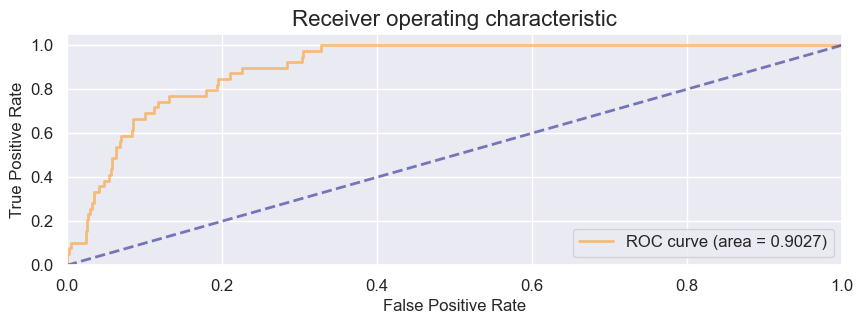

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1393
           1       1.00      0.03      0.05        39

    accuracy                           0.97      1432
   macro avg       0.99      0.51      0.52      1432
weighted avg       0.97      0.97      0.96      1432



0.9027187218141992

In [191]:
# Строим график ROC-AUC
roc_auc = plot_roc_auc(y_true=y_test, y_pred=average_proba_predict[:,1])
print(classification_report(y_true=y_test, y_pred=[1 if pred >= 0.5 else 0 for pred in average_proba_predict[:,1]]))
roc_auc

# Формирование submit

In [587]:
%%time
test_filename = PATH_DATASETS + "test.csv"
submit_X_test_df = pd.read_csv(test_filename, parse_dates=["report_date"], sep=';')
submit_X_test_df.shape

Wall time: 1.48 s


D:\_Work\_Projects\_Conda\DLS2\lib\site-packages\IPython\core\magics\execution.py:1335: DtypeWarning: Columns (50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,86,87,88,90,94,95,96,98,130,131,132,134,135,139,140,141,143,144,145,146,147,150,151,154,155,156,157,158,159,160,162,163,164,166,167,168,171,172,173,174,175,176,177,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,202,203,206,207,210,211,212,214,215,238,239,240,242,243,244,458,466,562,566,570,574,578,579,582,610,611,794,798,1030,1031,1032,1033,1034,1035,1036,1038,1039,1046,1054,1062,1063,1070,1071,1072,1073,1174,1175,1176,1177,1178,1179,1180,1181,1276,1277,1280,1281,1446,1447,1448,1449,1450,1451,1452,1453,1652,1653,1655,2192,2193,2194,2195,2198) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


(3642, 2666)

In [588]:
# Для теста выбираем признаки такие же которые используются в train
submit_X_test_df = submit_X_test_df[feature_columns]
submit_X_test_df.shape

(3642, 345)

# Заполняем пропуски в тестовых данных
Заполняем пропуски по тем же праивлам как и обучающую выборку

In [589]:
#prevent SettingWithCopyWarning message from appearing
pd.options.mode.chained_assignment = None

In [590]:
# Если параметр точно не категориальный, т.е. кардинальность высокая, то пропуски заполняем медианной
# Если параметр вероятнее всего категориальный, то заполняем пропуски как новая категория
# Все неопределенные заполняем самым частым значением
# Заполняем пропуски частовстречающимися значениями
for cat_col in cat_columns:
    submit_X_test_df[cat_col] = submit_X_test_df[cat_col].fillna("unknown").astype(str)
    
# Заполняем медианными значениями
for num_col in number_columns:
    median_value = df_train[num_col].median()
    submit_X_test_df[num_col] = submit_X_test_df[num_col].fillna(median_value)

# Заполняем пропуски частовстречающимися значениями
for other_col in other_columns:
    frequent_value = df_train[other_col].value_counts().index[0]
    submit_X_test_df[other_col] = submit_X_test_df[other_col].fillna(frequent_value)

In [591]:
# Проверяем что не осталось NaN
nan_df = submit_X_test_df[feature_columns].isna().sum()
nan_df[nan_df > 0]

Series([], dtype: int64)

### Формируем итоговые обучающие выборки

In [592]:
X_train = df_train[feature_columns]
y_train = df_train[target_column]

X_test = submit_X_test_df[feature_columns]

X_train.shape, y_train.shape, X_test.shape

((14309, 345), (14309,), (3642, 345))

In [593]:
# Обучаем итоговую модель

In [594]:
scale_pos_weight = len(df_train[df_train['target']==0])/len(df_train[df_train['target']==1])
prc_weight = min(y_train.value_counts())/max(y_train.value_counts())
result_classifiers = [
               ['BalancedBaggingClassifier :', BalancedBaggingClassifier(n_estimators=200, max_samples=prc_weight, random_state=53)],
               ['EasyEnsembleClassifier :', EasyEnsembleClassifier(random_state=53)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier(class_weight=class_weights, random_state=53)],
               ['RandomForest :', RandomForestClassifier(n_estimators=200, class_weight=class_weights, random_state=53)],
               ['AdaBoostClassifier :', AdaBoostClassifier(random_state=53)],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier(random_state=53)],
               ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=53)],
               ['CatBoost :', CatBoostClassifier(class_weights=class_weights, cat_features=cat_columns, verbose=False, random_state=53)]
]
        

In [595]:
submit_proba_predictions = []
for name, model in tqdm(result_classifiers):
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    submit_proba_predictions.append(model.predict_proba(X_test))
len(submit_proba_predictions)

  0%|          | 0/8 [00:00<?, ?it/s]

BalancedBaggingClassifier :


 12%|█▎        | 1/8 [00:05<00:37,  5.42s/it]

EasyEnsembleClassifier :


 25%|██▌       | 2/8 [00:17<00:56,  9.47s/it]

ExtraTreesClassifier :


 38%|███▊      | 3/8 [00:22<00:35,  7.17s/it]

RandomForest :


 50%|█████     | 4/8 [00:30<00:30,  7.57s/it]

AdaBoostClassifier :


 62%|██████▎   | 5/8 [00:36<00:20,  6.97s/it]

GradientBoostingClassifier: 


 75%|███████▌  | 6/8 [01:00<00:26, 13.00s/it]

LGBM :


 88%|████████▊ | 7/8 [01:02<00:09,  9.25s/it]

CatBoost :


100%|██████████| 8/8 [01:38<00:00, 12.28s/it]


8

In [596]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(submit_proba_predictions), axis=0)
submit_X_test_df['target'] = average_proba_predict[:,1]

In [597]:
# Формируем submit
submit_X_test_df[['target']].reset_index().rename(columns={'index':'id'}).set_index('id').to_csv(submission_filename, sep=';')

### Эксперименты с предсказаниями

In [616]:
result_classifiers = [
               ['BalancedBaggingClassifier :', BalancedBaggingClassifier( random_state=53)],
               ['EasyEnsembleClassifier :', EasyEnsembleClassifier(n_estimators=20, random_state=53)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier( class_weight=class_weights, random_state=53)],
               ['RandomForest :', RandomForestClassifier( class_weight=class_weights, random_state=53)],
               ['AdaBoostClassifier :', AdaBoostClassifier( random_state=53)],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier( random_state=53)],
               ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=53)],
               ['CatBoost :', CatBoostClassifier(class_weights=class_weights, cat_features=cat_columns, verbose=False, random_state=53)],
]
        
    
    
result_classifiers = [
               ['BalancedBaggingClassifier :', BalancedBaggingClassifier( random_state=42)],
               ['EasyEnsembleClassifier :', EasyEnsembleClassifier(n_estimators=20, random_state=42)],
               ['ExtraTreesClassifier :', ExtraTreesClassifier(class_weight=class_weights, random_state=42)],
               ['RandomForest :', RandomForestClassifier(class_weight=class_weights, random_state=42)],
               ['AdaBoostClassifier :', AdaBoostClassifier(random_state=42)],
               ['GradientBoostingClassifier: ', GradientBoostingClassifier( random_state=42)],
               ['LGBM :', LGBMClassifier(scale_pos_weight=scale_pos_weight, verbose=-1, random_state=42)],
               ['CatBoost :', CatBoostClassifier(class_weights=class_weights, cat_features=cat_columns, verbose=False, random_state=42)],
]
        

In [617]:
%%time
submit_proba_predictions = []
for name, model in tqdm(result_classifiers):
    print(name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    submit_proba_predictions.append(model.predict_proba(X_test))
len(submit_proba_predictions)

  0%|          | 0/8 [00:00<?, ?it/s]

BalancedBaggingClassifier :


 12%|█▎        | 1/8 [00:02<00:15,  2.18s/it]

EasyEnsembleClassifier :


 25%|██▌       | 2/8 [00:24<01:25, 14.22s/it]

ExtraTreesClassifier :


 38%|███▊      | 3/8 [00:28<00:47,  9.59s/it]

RandomForest :


 50%|█████     | 4/8 [00:32<00:29,  7.36s/it]

AdaBoostClassifier :


 62%|██████▎   | 5/8 [00:38<00:20,  6.83s/it]

GradientBoostingClassifier: 


 75%|███████▌  | 6/8 [01:02<00:24, 12.47s/it]

LGBM :


 88%|████████▊ | 7/8 [01:03<00:08,  8.85s/it]

CatBoost :


100%|██████████| 8/8 [01:36<00:00, 12.12s/it]

Wall time: 1min 36s


8

In [618]:
# Усреднение вероятностей
average_proba_predict = np.mean(np.array(submit_proba_predictions), axis=0)
submit_X_test_df['target'] = average_proba_predict[:,1]

In [619]:
# Формируем submit
submit_X_test_df[['target']].reset_index().rename(columns={'index':'id'}).set_index('id').to_csv(submission_filename, sep=';')


##### Посылки на лидерборд  
- 1_submission.csv - 0.817152
- 2_submission.csv - 0.816508
- 3_submission.csv - 0.817275
- 4_submission.csv - 0.817394
- 5_submission.csv - 0.818089
- 6_submission.csv - 0.816640
- 7_submission.csv - 0.819618
- 8_submission.csv - 0.821961
- 9_submission.csv - 0.820377
- 10_submission.csv - 0.820377
- 11_submission.csv - 0.818767 
- 12_submission.csv - 0.821961
- 13_submission.csv - 0.823114
- 14_submission.csv -  0.810407
- 15_submission.csv - 0.823114
- 16_submission.csv - 0.821050
- 17_submission.csv - 0.823516
- 18_submission.csv - 0.818063
